In [15]:
import joblib
from src import utils
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [16]:
# Buat akses menuju data validasi
X_val_data_path = './data/processed/X_valid_prep.pkl'
y_val_data_path = './data/processed/y_valid_prep.pkl' 

# Panggil fungsi deserialisasi untuk menampilkan data validasi
X_valid_prep = utils.deserialize_data(X_val_data_path)
y_valid_prep = utils.deserialize_data(y_val_data_path)

# Panggil model yang sudah dilatih
models = {
    'RandomForest': joblib.load('models/trained_RandomForest.pkl'),
    'DecisionTree': joblib.load('models/trained_DecisionTree.pkl'),
    'KNN'         : joblib.load('models/trained_KNearestNeighbor.pkl')
}

In [17]:
def threshold_tuning(model, X_val, y_val):
    """
    Melakukan penyetelan ambang batas untuk model yang telah dilatih pada data validasi.

    Parameter
    model  : Model yang telah dilatih
    X_val  : Data fitur validasi
    y_val  : Data target validasi
    metric : Metrik yang diinginkan untuk evaluasi ('roc_auc')

    Return
    results: Daftar bertipe dict yang berisi nama model, ambang batas, dan nilai metrik
    """

    probas    = model.predict_proba(X_val)[:, 1]
    thresholds= np.linspace(0, 1, 100)
    results   = []

    for threshold in thresholds:
        y_preds = (probas >= threshold).astype(int)        
        roc_auc = roc_auc_score(y_val, y_preds)


        results.append({
            'model_name': type(model).__name__,
            'threshold' : threshold,
            'metric'    : roc_auc
        })
    
    return results

# Lakukan penyetelan ambang batas pada semua model
tuning_results = []
for model_name, model in models.items():
    print(f"Threshold tuning for {model_name}...")
    results = threshold_tuning(models[model_name], X_valid_prep, y_valid_prep)
    tuning_results.extend(results)
    print(pd.DataFrame(tuning_results))
    print()


Threshold tuning for RandomForest...
                model_name  threshold    metric
0   RandomForestClassifier   0.000000  0.500000
1   RandomForestClassifier   0.010101  0.593461
2   RandomForestClassifier   0.020202  0.625198
3   RandomForestClassifier   0.030303  0.654252
4   RandomForestClassifier   0.040404  0.675831
..                     ...        ...       ...
95  RandomForestClassifier   0.959596  0.718706
96  RandomForestClassifier   0.969697  0.691983
97  RandomForestClassifier   0.979798  0.665260
98  RandomForestClassifier   0.989899  0.623769
99  RandomForestClassifier   1.000000  0.568214

[100 rows x 3 columns]

Threshold tuning for DecisionTree...
                 model_name  threshold    metric
0    RandomForestClassifier   0.000000  0.500000
1    RandomForestClassifier   0.010101  0.593461
2    RandomForestClassifier   0.020202  0.625198
3    RandomForestClassifier   0.030303  0.654252
4    RandomForestClassifier   0.040404  0.675831
..                      ...    

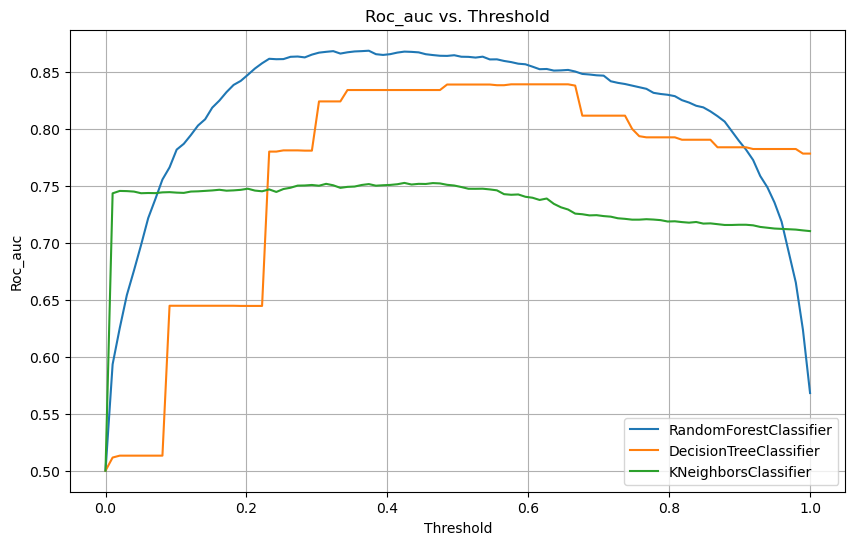

In [18]:
def plot_metrics_vs_threshold(results, metric):
    """
    Membuat plot metrik ambang batas untuk beberapa model.

    Parameter
    results : Daftar dict yang berisi nama model, ambang batas, dan nilai metrik
    metric  : Metrik (dalam bentuk string) yang akan diplot terhadap ambang batas.

    Return
    None
    """
    df = pd.DataFrame(results)
    plt.figure(figsize=(10, 6))
    
    for model_name in df['model_name'].unique():
        subset = df[df['model_name'] == model_name]
        plt.plot(subset['threshold'], subset['metric'], label=model_name)
    
    plt.xlabel('Threshold')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot hasil
plot_metrics_vs_threshold(tuning_results, metric='roc_auc')


--Catatan:
Dapat dilihat bahwa RandomForestClassifier memiliki kurva yang lebih baik dibandingkan dua algoritma lainnya. 

In [ ]:
def select_best_threshold(tuning_results, save_path):
    """
    Pilih ambang batas terbaik berdasarkan metrik yang diinginkan dari hasil penyetelan.

    Parameter
    tuning_results: Daftar dict yang berisi nama model, ambang batas, dan nilai metrik
    save_path     : lokasi folder untuk menyimpan informasi ambang batas terbaik

    Return
    best_threshold: Daftar bertipe dice yang menyimpan informasi mengenai ambang batas terbaik
    """

    df = pd.DataFrame(tuning_results)
    best_threshold = df.loc[df['metric'].idxmax()].to_dict()

    threshold_path = 'models/threshold.json'
    
    utils.serialize_data(best_threshold, threshold_path)

    return best_threshold

# Pilih ambang batas terbaik
best_threshold = select_best_threshold(tuning_results, 'best_threshold.json')
print("Best Threshold:", best_threshold)


Best Threshold: {'model_name': 'RandomForestClassifier', 'threshold': 0.37373737373737376, 'metric': 0.8688156331847346}


--Catatan
Model terbaik adalah RandomForestClassifier. Model ini melakukan klasifikasi pada ambang batas 0.37 untuk membedakan status default atau non default dengan evaluasi metric sebesar 0.86

In [20]:
# Buat akses menuju data uji
X_test_data_path = './data/processed/X_test_prep.pkl'
y_test_data_path = './data/processed/y_test_prep.pkl' 

# Panggil fungsi deserialisasi untuk menampilkan data uji
X_test_prep = utils.deserialize_data(X_test_data_path)
y_test_prep = utils.deserialize_data(y_test_data_path)

def evaluate_model(model, best_threshold, X_test, y_test):
    """
    Evaluasi model pada data uji menggunakan ambang batas terbaik.

    Parameter
    model         : Model yang telah dilatih
    best_threshold: daftar berisi informasi mengenai ambang batas terbaik
    X_test        : Data fitur uji
    y_test        : Data target uji

    Return
    None
    """

    probas = model.predict_proba(X_test)[:, 1]
    threshold = best_threshold['threshold']
    y_preds = (probas >= threshold).astype(int)
        
    roc_auc = roc_auc_score(y_test, y_preds)
    print(roc_auc)


In [21]:
# Evaluasi model terbaik dengan ambang batas terbaik 
best_model      = models['RandomForest']
evaluate_model(best_model, best_threshold, X_test_prep, y_test_prep)

0.8579322024168317


--Catatan: 
Setelah diuji pada data tes, performa RandomForestClassifier sebesar 0.85, nilai evaluasi yang menunjukkan kinerja model yang baik dalam membedakan kelas default\gagal bayar (1) dan non default\non gagal bayar (0). 